# Conservation Diagnostics in the LFRic-Atmosphere Temperature Forcing runs

## Import libraries

Standard library

In [1]:
import warnings

warnings.filterwarnings("ignore")

External modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from aeolus.io import load_conservation_diag
from aeolus.plot import (
    add_custom_legend,
    capitalise,
    figsave,
    subplot_label_generator,
    tex2cf_units,
)

Local modules

In [4]:
import paths
from shared import MODELS, TF_CASES, THAI_CASES

In [5]:
plt.style.use("custom.mplstyle")

## Load diagnostics

Load Temperature Forcing runs, only LFRic-Atmosphere

In [6]:
SIM_CASES = TF_CASES  # THAI_CASES
MODELS.pop("um")

{'model': Model [99 fields],
 'data_proc_path': PosixPath('/home/ds591/exoplanets/lfric_exo_bench_proj/data/proc/um'),
 'data_raw_path': PosixPath('/home/ds591/exoplanets/lfric_exo_bench_proj/data/raw/um'),
 'title': 'UM',
 'kw_plt': {'linestyle': '--', 'linewidth': 0.75, 'dash_capstyle': 'round'}}

In [7]:
runs = {}
for model_key, model_prop in MODELS.items():
    runs[model_key] = {}

    for sim_label, sim_prop in SIM_CASES.items():
        try:
            runs[model_key][sim_label] = load_conservation_diag(
                (model_prop["data_raw_path"] / sim_label).glob(
                    "*/*/conservation_diag.dat"
                )
            )
        except ValueError as e:
            print(model_key, sim_label)

## Plot diagnostics

Define diagnostics and their plotting metadata

In [8]:
DIAGS = {
    "rho": {
        "name": "total_atmosphere_mass",
        "tex_units": r"$10^{18}$ $kg$",
        "lim": [5.0745, 5.075],
    },
    "aam": {
        "name": "total_axial_angular_momentum",
        "tex_units": r"$10^{28}$ $kg$ $m^2$ $s^{-1}$",
        "lim": [0, 1.5],
    },
    "ke": {
        "name": "total_kinetic_energy",
        "tex_units": r"$10^{21}$ $kg$ $m^2$ $s^{-2}$",
        "lim": [0, 1],
    },
}

Normalise the time series by their maximum value

In [9]:
normalise = True

Construct the figure and save it

Saved to ../figures/exf__lfric__hs_el_tle__rho_aam_ke.png


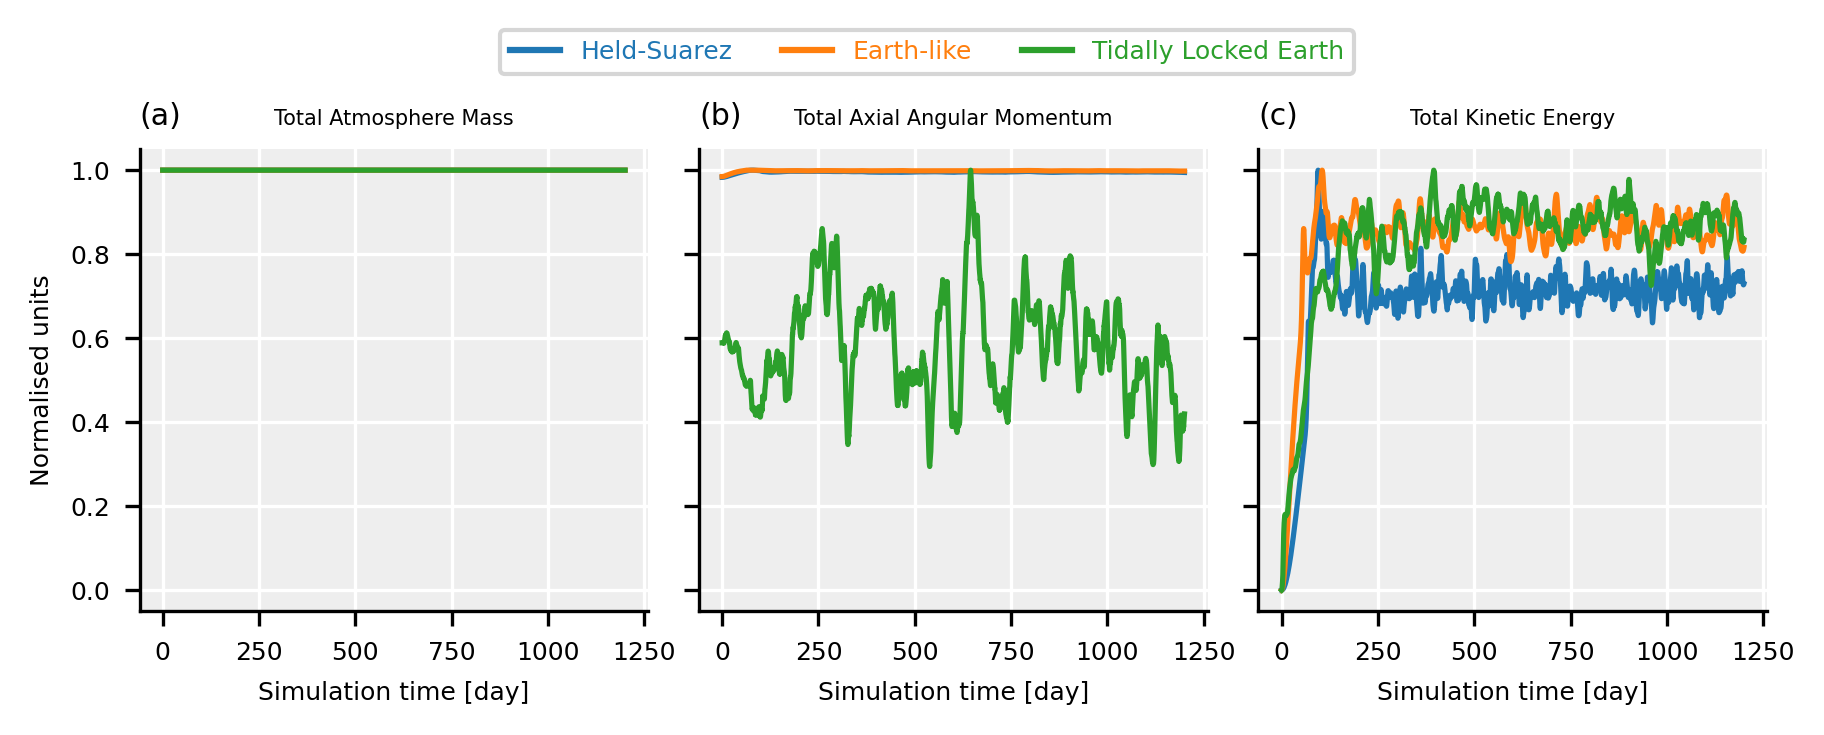

In [10]:
fig = plt.figure(figsize=(7, 2), tight_layout=True)
# fig.suptitle("Conservation diagnostics", y=1.15)
axd = fig.subplot_mosaic(
    [DIAGS.keys()],
    gridspec_kw={"wspace": 0.1 if normalise else 0.4},
    sharex=True,
    sharey=normalise,
)
iletters = subplot_label_generator()
for ax in axd.values():
    ax.set_title(f"({next(iletters)})", loc="left")

for model_key, model_prop in MODELS.items():
    # if model_key == "lfric":
    # continue
    for diag_key, diag_prop in DIAGS.items():
        ax = axd[diag_key]
        ax.set_title(capitalise(diag_prop["name"]), size="small")
        if normalise:
            # ax.set_ylim(0, 1.1)
            if ax.get_subplotspec().is_first_col():
                ax.set_ylabel("Normalised units")
        else:
            ax.set_ylim(diag_prop["lim"])
            ax.set_ylabel(rf"[$\times${diag_prop['tex_units']}]")
        # ax.set_xlim(0, 1200)
        # ax.set_xticks(np.arange(0, 1201, 200), dtype=int)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Simulation time [day]")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.grid(color="w")
        ax.set_facecolor("#EEEEEE")

        for sim_label, sim_prop in SIM_CASES.items():
            try:
                cube = runs[model_key][sim_label].extract_cube(diag_prop["name"])
            except KeyError as e:
                print(e)
                continue
            if not normalise:
                cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
            days = cube.coord("timestep").points * sim_prop["timestep"] / 86400
            if sim_label.startswith("tle") and diag_key == "aam" and not normalise:
                factor = 365
                # extra_note = "\n" + rf"($\times${factor})"
                extra_note = rf"$\times${factor}"
            else:
                factor = 1
                extra_note = ""
            x = days
            y = cube.copy().data * factor
            if normalise:
                y /= y.max()
                # y /= np.linalg.norm(y, ord=1)
                # y /= (sum(y**2))**0.5
            ax.plot(x, y, **sim_prop["kw_plt"], **model_prop["kw_plt"])
            # ax.annotate(
            #     text=sim_prop["short_title"] + extra_note,
            #     xy=(x[-1], y[-1]),
            #     xytext=(1, 0),
            #     textcoords="offset points",
            #     va="center",
            #     color=sim_prop["kw_plt"]["color"],
            #     fontsize="small",
            #     weight="bold",
            # )
            if sim_label.startswith("tle") and diag_key == "aam":
                ax.text(
                    0.90,
                    0.85,
                    s=extra_note,
                    va="center",
                    ha="center",
                    color=sim_prop["kw_plt"]["color"],
                    fontsize="small",
                    weight="bold",
                    transform=ax.transAxes,
                )
add_custom_legend(
    fig,
    {v["title"]: {**v["kw_plt"]} for v in SIM_CASES.values()},
    ncol=len(SIM_CASES),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
)
# add_custom_legend(
#     fig,
#     {v["title"]: {"color": "k", **v["kw_plt"]} for v in MODELS.values()},
#     ncol=len(MODELS),
#     loc="upper center",
#     bbox_to_anchor=(0.5, 1.1),
# )
figsave(
    fig,
    paths.figures
    # / "drafts"
    / f"exf__{'_'.join(MODELS.keys())}__{'_'.join(SIM_CASES.keys())}__{'_'.join(DIAGS.keys())}",
)